# Group Data Generation Example
For the group data generation, the probability to have a true positive label is dependant on the previous predictions of the whole group sharing the protecetd attribute. The whole group moves towards positive cluster depending on the sum of positive predictions for the whole group. 

In [1]:
import sys
import numpy as np
sys.path.append("../")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from long_term_fairness.ltf_plot import LongTermFairnessPlot
from long_term_fairness.ltf_data.group_data_generator import GroupDataGenerator
from long_term_fairness.ltf_aif.longterm_aif import AifLongTermMetric, AifLongTermPrediction

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The generator.
generator = GroupDataGenerator(mean_pos=[0, 1],
                               mean_neg=[12, 11],
                               num_positive_label=100,
                               num_negative_label=100,
                               discrimination_factor=.9)

In [4]:
# The helper class is necessary to use sklearn with the ltf framework.
class CLF:
    def __init__(self, clf=LogisticRegression()):
        self.c = clf
    def predict(self, X, X_s):
        return self.c.predict(X)
    def fit(self, X, X_s, y):
        self.c.fit(X, y)     

## 1. Unconstrained Example
The first example is unconstrained again. The learned decision boundary is closer to the real boundary now, because a linear support vector machine is trained as baseline model.

Only positive decisions have an impact on the group here, and individuals move towards the positive cluster proportional to the sum of predictions. Therefore individuals from the unprotected group change their true label in both baseline and true data while those from the protected group only move slowly towards to other cluster and do not change labels in 6 generations.

In [5]:
# The long term metric with default options (disparate impact and accuracy).
metric = AifLongTermMetric()

In [6]:
# The clf, this time a linear support vector machine.
clf = CLF(LinearSVC())

In [7]:
# The plot generator.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

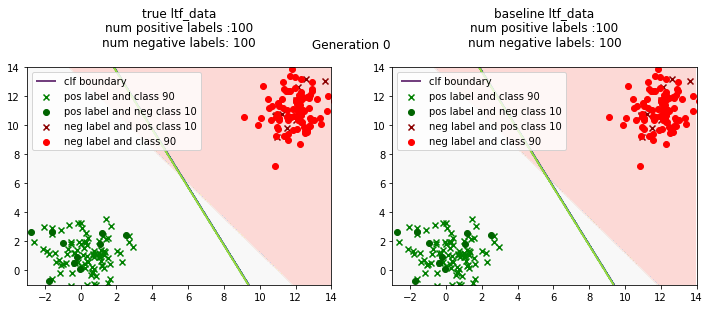

In [8]:
# Init the data and plot the first generation.
l.init_data()
l.plot_generation()

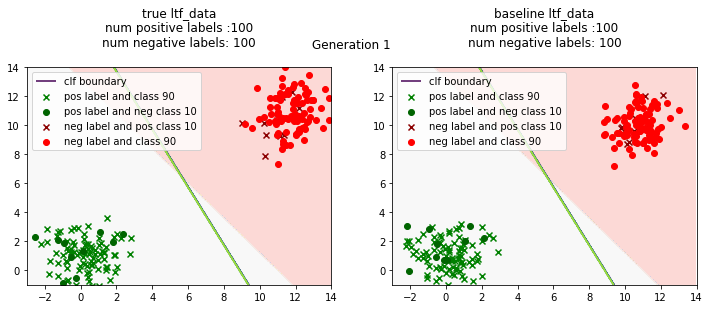

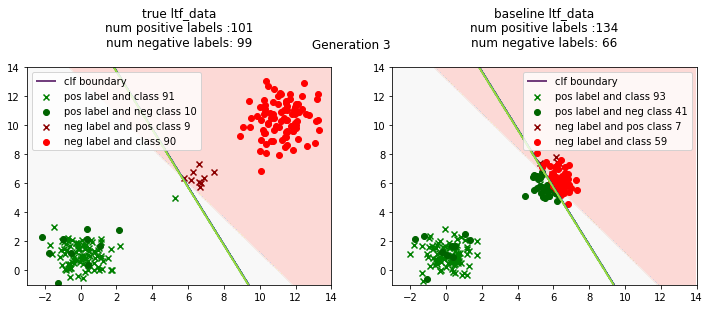

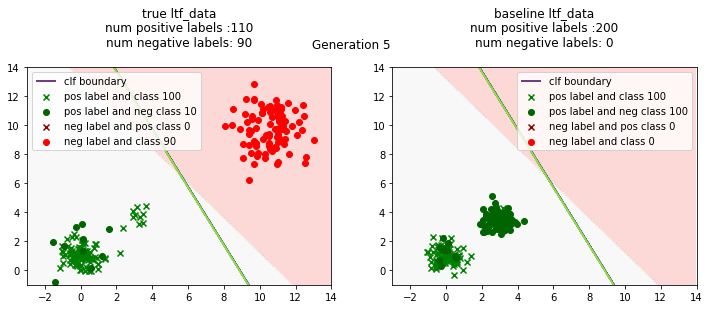

In [9]:
# Run six generations with clf updated after each step.
for i in range(6):

    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

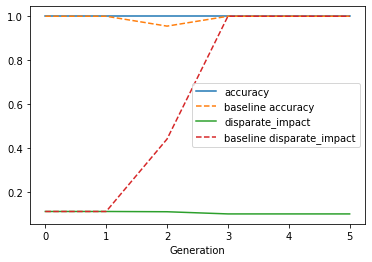

In [10]:
l.plot_ltf(metric._metrics)

The plot is basically the same as in the previous section with the individual data generation, except that the accuracy decrease in the baseline pipeline is smaller now, due to the better decision function. Also disparate impact decreases now.

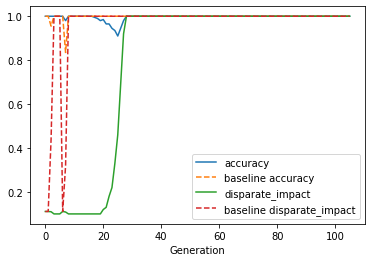

In [11]:
# Run 100 generations again.
l.run(100)
l.plot_ltf(metric._metrics)

Even in the unconstrained example, all individuals move towards the positive cluster towards the end. The growth becomes exponential, when the number of positive labeled individuals starts to increase.

## 2. Constrained Example
The constrained example again uses the artificial decision rule.

In [12]:
# Fair artificial decision rule. The artificial decision rule is necessary, to produce the desired result...
class FairCLF:
    def predict(self, X, X_s):
        pred = [5, -12] @ X.T + 50
        
        pred[pred>0] = 1
        pred[pred<0] = 0
        
        return np.sign(pred)
    def fit(self, X, X_s, y):
        pass

In [13]:
# The artificial fair clf.
clf = FairCLF()

In [14]:
# The ltf plot.
l = LongTermFairnessPlot(generator, clf, metric.metric, x_lim=[-3, 14], y_lim=[-1, 14])

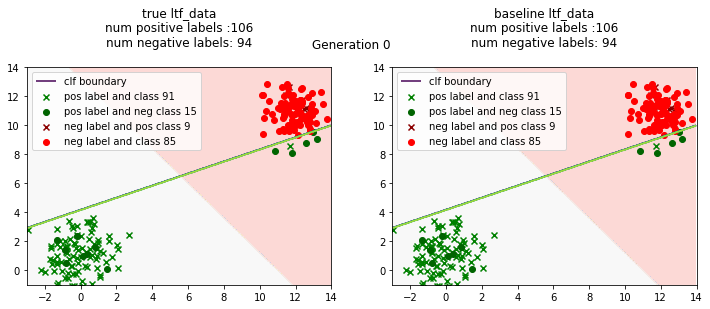

In [15]:
# Init and plot data.
l.init_data()
l.plot_generation()

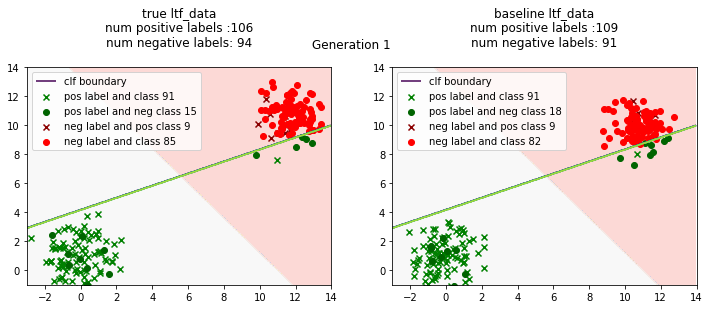

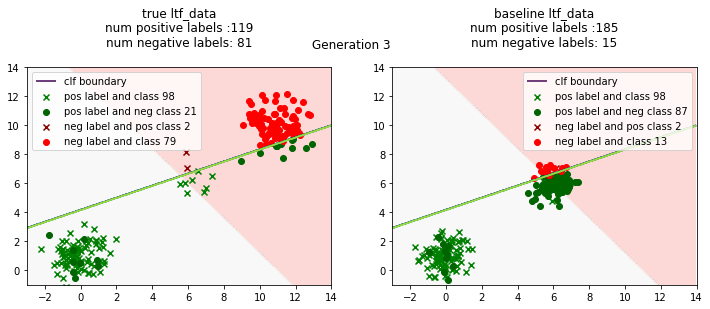

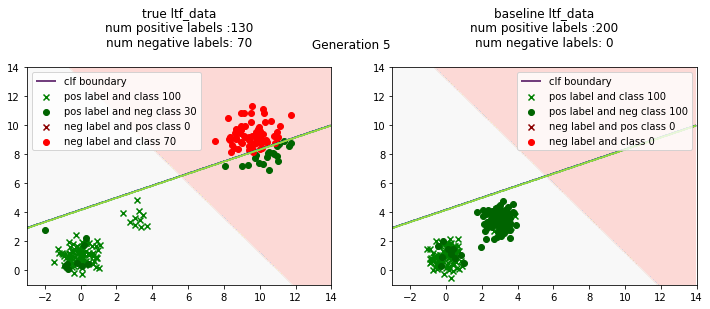

In [16]:
# Run six iterations.
for i in range(6):
    l.run_generation()
    l.run_baseline_generation()
    if i % 2 == 0:
        l.plot_generation()

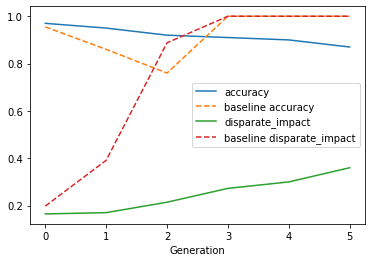

In [17]:
# Plot the results after 6 iterations.
l.plot_ltf(metric._metrics)

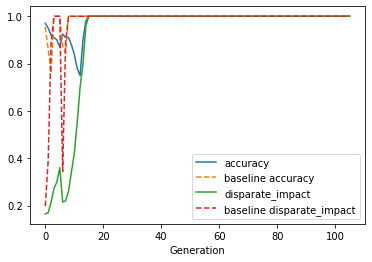

In [18]:
# Run another 100 iterations.
l.run(100)
l.plot_ltf(metric._metrics)

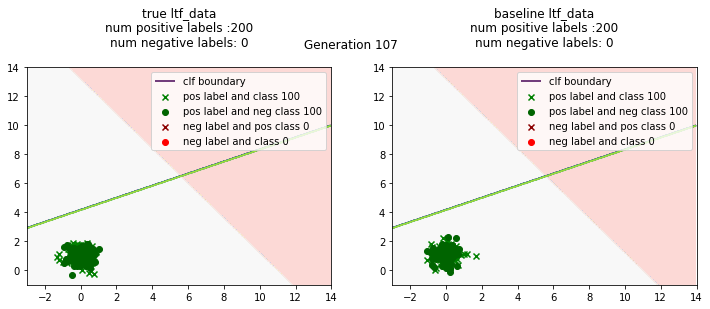

In [19]:
l.plot_generation()

Again, all points are positive labeled after some time, but due to the constrained decision function, this happens much earlier.

### 3. Conclusion
In this example, all individuals benefit from positive decisions in the same way. Therefore, the whole group slowly moves towards the positive cluster, but it takes very long since only a few individuals of the protected group have a positive label. Note, that negative labels do not have an impact on the group here (this would remove the impact of the positive labels otherwise).

As improvement, individuals with positive label should move faster to the positive cluster (i.e.closer points should benefit more from decisions). Also, the negative label should also have an impact.